## Read Input Data

In [1]:
import pickle
import gzip

In [2]:
with gzip.open("/home/jg/Downloads/ericsson-mnist-assignment.pkl.gz") as f:
    data, labels = pickle.load(f, encoding="latin1")
f.close()

## Verify data

In [3]:
data.shape

(30000, 28, 28)

In [4]:
set(labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

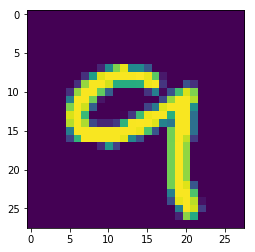

In [6]:
import matplotlib.pyplot as plt
plt.imshow(data[0])

## Train, test split

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=0)

In [8]:
[X_train.shape, X_test.shape, y_train.shape, y_test.shape]

[(21000, 28, 28), (9000, 28, 28), (21000,), (9000,)]

## Model Build

In [9]:
import tensorflow as tf
tf.__version__

'1.6.0'

In [10]:
# The MNIST dataset has 10 classes, representing the digits 0 through 9.
NUM_CLASSES = 10

# The MNIST images are always 28x28 pixels.
IMAGE_SIZE = 28
IMAGE_PIXELS = IMAGE_SIZE * IMAGE_SIZE

def inference(images, hidden1_units, hidden2_units):
  # Hidden 1
  with tf.name_scope('hidden1'):
    weights = tf.Variable(
        tf.truncated_normal([IMAGE_PIXELS, hidden1_units],
                            stddev=1.0 / math.sqrt(float(IMAGE_PIXELS))),
        name='weights')
    biases = tf.Variable(tf.zeros([hidden1_units]),
                         name='biases')
    hidden1 = tf.nn.relu(tf.matmul(images, weights) + biases)
  # Hidden 2
  with tf.name_scope('hidden2'):
    weights = tf.Variable(
        tf.truncated_normal([hidden1_units, hidden2_units],
                            stddev=1.0 / math.sqrt(float(hidden1_units))),
        name='weights')
    biases = tf.Variable(tf.zeros([hidden2_units]),
                         name='biases')
    hidden2 = tf.nn.relu(tf.matmul(hidden1, weights) + biases)
  # Linear
  with tf.name_scope('softmax_linear'):
    weights = tf.Variable(
        tf.truncated_normal([hidden2_units, NUM_CLASSES],
                            stddev=1.0 / math.sqrt(float(hidden2_units))),
        name='weights')
    biases = tf.Variable(tf.zeros([NUM_CLASSES]),
                         name='biases')
    logits = tf.matmul(hidden2, weights) + biases
  return logits


def loss(logits, labels):
  labels = tf.to_int64(labels)
  return tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)


def training(loss, learning_rate):
  # Add a scalar summary for the snapshot loss.
  tf.summary.scalar('loss', loss)
  # Create the gradient descent optimizer with the given learning rate.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  # Create a variable to track the global step.
  global_step = tf.Variable(0, name='global_step', trainable=False)
  # Use the optimizer to apply the gradients that minimize the loss
  # (and also increment the global step counter) as a single training step.
  train_op = optimizer.minimize(loss, global_step=global_step)
  return train_op


def evaluation(logits, labels):
  # For a classifier model, we can use the in_top_k Op.
  # It returns a bool tensor with shape [batch_size] that is true for
  # the examples where the label is in the top k (here k=1)
  # of all logits for that example.
  correct = tf.nn.in_top_k(logits, labels, 1)
  # Return the number of true entries.
  return tf.reduce_sum(tf.cast(correct, tf.int32))

## Main - Tensorflow Graph

In [11]:
x = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))
y = tf.matmul(x, W) + b

y_ = tf.placeholder(tf.int64, [None])

cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=y_, logits=y)
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)


In [12]:
tf.reset_default_graph

<function tensorflow.python.framework.ops.reset_default_graph()>

In [13]:
sess = tf.InteractiveSession()

In [14]:
tf.get_default_graph

<function tensorflow.python.framework.ops.get_default_graph()>

In [15]:
tf.global_variables_initializer().run()

In [16]:
W.get_shape()

TensorShape([Dimension(784), Dimension(10)])

In [17]:
[X_train.shape, X_test.shape, y_train.shape, y_test.shape]

[(21000, 28, 28), (9000, 28, 28), (21000,), (9000,)]

In [18]:
import numpy as np

In [19]:
def iterate_minibatches(inputs, targets, batchsize):
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        batch_X = inputs[start_idx : start_idx + batchsize]
        batch_y = targets[start_idx : start_idx + batchsize]
        return batch_X, batch_y

In [20]:
batch_xs, batch_ys = iterate_minibatches(X_train, y_train, 100)
[batch_xs.reshape(-1, 784).shape, batch_ys.reshape(-1, 10).shape]

[(100, 784), (10, 10)]

In [24]:
for _ in range(32):
    for _ in range(1000):
        batchsize = 512
        batch_xs, batch_ys = iterate_minibatches(X_train, y_train, batchsize)
        sess.run(train_step, feed_dict={x: batch_xs.reshape(-1, 784), y_: batch_ys})

In [25]:
[X_test.reshape(-1, 784).shape, y_test.shape]

[(9000, 784), (9000,)]

## Evaluate

In [26]:
correct_prediction = tf.equal(tf.argmax(y, 1), y_)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(
      accuracy, feed_dict={
          x: X_test.reshape(-1, 784),
          y_: y_test
}))

0.73


In [27]:
tf.summary.scalar('accuracy', accuracy)
merged = tf.summary.merge_all()

train_writer = tf.summary.FileWriter('/home/jg/ericson/train', sess.graph)